HuberRegressor model:
Intercept: 6.853107855749784e-10
Coefficient: 3.736520867023467e-05
Training R2 Score: 0.12711009619084812
Number of rows with missing power to impute: 430


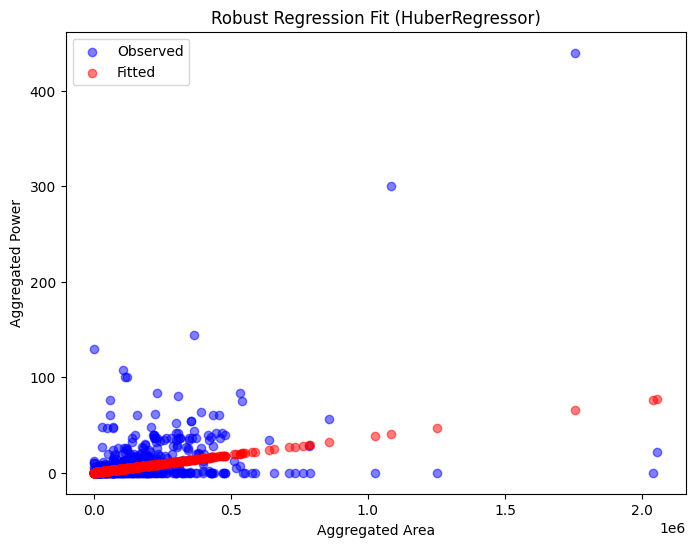

Missing aggregated_power after imputation: 16.22%


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


merged_dataset = pd.read_csv("merged_dataset.csv")

facilities_with_yob = merged_dataset[merged_dataset["yearbuilt"].notnull()].copy()

# ---------------------------
# Step 1: Prepare Data for Robust Regression
# ---------------------------
# Assume your dataset is in facilities_with_yob
df = facilities_with_yob.copy()

# Subset data that have both aggregated_power and aggregated_area to train the model
df_train = df.dropna(subset=["aggregated_power", "aggregated_area"]).copy()

# Use aggregated_area as the predictor and aggregated_power as the target
X_train = df_train[["aggregated_area"]].values
y_train = df_train["aggregated_power"].values

# ---------------------------
# Step 2: Fit a Robust Regression Model using HuberRegressor
# ---------------------------
# HuberRegressor is robust to outliers.
robust_model = HuberRegressor()
robust_model.fit(X_train, y_train)

# Print model parameters
print("HuberRegressor model:")
print("Intercept:", robust_model.intercept_)
print("Coefficient:", robust_model.coef_[0])

# Optionally, evaluate the model performance on the training data
y_pred = robust_model.predict(X_train)
print("Training R2 Score:", r2_score(y_train, y_pred))

# ---------------------------
# Step 3: Impute Missing aggregated_power Using the Robust Model
# ---------------------------
# Identify rows missing aggregated_power but with a valid aggregated_area
mask_missing_power = df["aggregated_power"].isna() & df["aggregated_area"].notna()
print("Number of rows with missing power to impute:", mask_missing_power.sum())

# Predict and fill the missing aggregated_power values
df.loc[mask_missing_power, "aggregated_power"] = robust_model.predict(
    df.loc[mask_missing_power, ["aggregated_area"]].values
)

# ---------------------------
# Step 4: Visualize the Regression Fit (Optional)
# ---------------------------
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, color='blue', alpha=0.5, label="Observed")
plt.scatter(X_train, y_pred, color='red', alpha=0.5, label="Fitted")
plt.xlabel("Aggregated Area")
plt.ylabel("Aggregated Power")
plt.title("Robust Regression Fit (HuberRegressor)")
plt.legend()
plt.show()

# ---------------------------
# Step 5: Check the Missingness After Imputation
# ---------------------------
missing_after = (df["aggregated_power"].isna().sum() / len(df)) * 100
print(f"Missing aggregated_power after imputation: {missing_after:.2f}%")

In [2]:
merged_dataset = pd.read_csv("merged_dataset.csv")

facilities_with_yob = merged_dataset[merged_dataset["yearbuilt"].notnull()].copy()

Correlation of aggregated_power with other numeric columns:
aggregated_power           1.000000
aggregated_area            0.425833
yearbuilt                  0.167561
latitude                   0.063173
data_center_count          0.028821
longitude                  0.014837
avg_name_similarity       -0.059834
avg_provider_similarity   -0.167653
Name: aggregated_power, dtype: float64


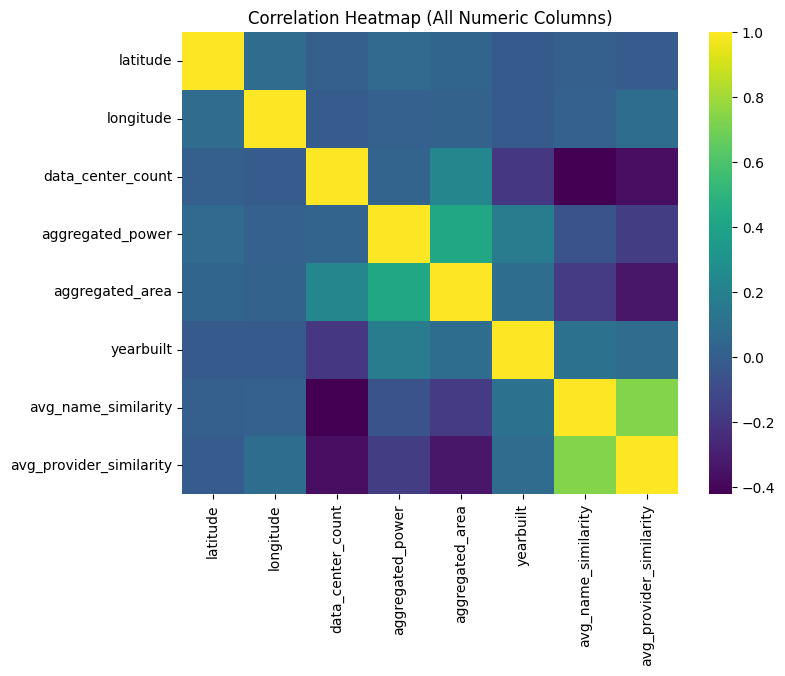

In [3]:
import pandas as pd
import numpy as np

# Copy your dataset (assuming it's in facilities_with_yob)
df = facilities_with_yob.copy()

# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Check if 'aggregated_power' is in those numeric columns
if 'aggregated_power' not in numeric_cols:
    print("'aggregated_power' is not found among numeric columns. Please verify your dataframe.")
else:
    # Compute correlation matrix for numeric columns
    corr_matrix = df[numeric_cols].corr()

    # Sort correlation values w.r.t. aggregated_power
    power_correlations = corr_matrix['aggregated_power'].sort_values(ascending=False)

    print("Correlation of aggregated_power with other numeric columns:")
    print(power_correlations)

    # (Optional) If you want to see a quick correlation heatmap:
    # (You can comment this out if not needed)
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(8,6))
    sns.heatmap(corr_matrix, annot=False, cmap="viridis")
    plt.title("Correlation Heatmap (All Numeric Columns)")
    plt.show()

## Observations from the Heatmap Analysis

Based on the heatmap visualization, the following correlations between variables and `aggregated_power` were observed:

1.  **Aggregated Area:**
    *   Demonstrates the **highest correlation** with `aggregated_power`.
    *   The correlation is **moderate** in strength.
    *   *Implication:* Larger data center areas tend to be associated with higher power consumption.

2.  **Data Center Count:**
    *   Exhibits a **smaller but still positive correlation** with `aggregated_power`.
    *   *Implication:* Regions with a higher density of data centers may have higher overall power usage.

3.  **Year Built:**
    *   Shows a **weak correlation** with `aggregated_power`.
    *   *Consideration:* Despite the weak correlation, it might be **worth including** in further analysis.
    *   *Reasoning:* Domain knowledge might suggest that newer data center builds could have different power usage patterns (e.g., more efficient or higher density).

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# 1. Prepare data (ensure you have these columns in facilities_with_yob)
df = facilities_with_yob.copy()

# Subset rows that have all required columns for modeling
required_cols = ["aggregated_power", "aggregated_area", "data_center_count", "yearbuilt", "facility_type"]
df_model = df.dropna(subset=required_cols).copy()

# 2. Convert facility_type into dummy variables
df_dummies = pd.get_dummies(df_model, columns=["facility_type"], drop_first=True)

# 3. Define features (X) and target (y)
feature_cols = ["aggregated_area", "data_center_count", "yearbuilt"] + [
    col for col in df_dummies.columns if col.startswith("facility_type_")
]
X = df_dummies[feature_cols].values
y = df_dummies["aggregated_power"].values

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Fit a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 6. Evaluate the model
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
print("Random Forest - Train R2:", r2_score(y_train, y_pred_train))
print("Random Forest - Test R2:", r2_score(y_test, y_pred_test))

# 7. (Optional) Inspect feature importance
importances = rf.feature_importances_
for col, imp in zip(feature_cols, importances):
    print(f"{col}: {imp:.3f}")

Random Forest - Train R2: 0.8557793931393752
Random Forest - Test R2: 0.11551520291682749
aggregated_area: 0.506
data_center_count: 0.127
yearbuilt: 0.322
facility_type_Campus: 0.024
facility_type_Individual: 0.021


In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

df = facilities_with_yob.copy()

# Subset rows that have all required columns
required_cols = ["aggregated_power", "aggregated_area", "data_center_count", "yearbuilt", "facility_type"]
df_model = df.dropna(subset=required_cols).copy()

# Apply log transform to power and area (shift by 1 if zero or near-zero possible)
df_model["log_power"] = np.log(df_model["aggregated_power"] + 1)
df_model["log_area"] = np.log(df_model["aggregated_area"] + 1)

# Convert facility_type into dummies
df_dummies = pd.get_dummies(df_model, columns=["facility_type"], drop_first=True)

# Define features (using log_area instead of aggregated_area)
feature_cols = ["log_area", "data_center_count", "yearbuilt"] + [
    col for col in df_dummies.columns if col.startswith("facility_type_")
]
X = df_dummies[feature_cols].values
y = df_dummies["log_power"].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a Random Forest model on the log-transformed data
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Evaluate model in log-space (R^2 on log scale)
print("Train R2 (log-power):", r2_score(y_train, y_pred_train))
print("Test R2 (log-power):", r2_score(y_test, y_pred_test))

# (Optional) Convert predictions back to original power scale
y_pred_test_original_scale = np.exp(y_pred_test) - 1

Train R2 (log-power): 0.9143027107297048
Test R2 (log-power): 0.3909629579282249


In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

df = facilities_with_yob.copy()

# We'll handle each facility_type individually
facility_types = df["facility_type"].dropna().unique()

models_by_type = {}

for ftype in facility_types:
    # Subset for this facility type
    df_sub = df.loc[
    (df["facility_type"] == ftype) &
    (df["aggregated_power"].notna()) &
    (df["aggregated_area"].notna())
    ].copy()  

    if len(df_sub) < 10:
        # Skip if not enough data
        continue
    
    # Optionally apply log transform
    df_sub["log_power"] = np.log(df_sub["aggregated_power"] + 1)
    df_sub["log_area"] = np.log(df_sub["aggregated_area"] + 1)
    
    X = df_sub[["log_area", "data_center_count", "yearbuilt"]].values
    y = df_sub["log_power"].values
    
    # Train a model (no train/test split here for brevity; do one if you prefer)
    rf = RandomForestRegressor(n_estimators=50, random_state=42)
    rf.fit(X, y)
    
    # Evaluate in-sample R^2 (for demonstration)
    y_pred = rf.predict(X)
    r2 = r2_score(y, y_pred)
    
    models_by_type[ftype] = (rf, r2)
    print(f"Facility Type: {ftype}, In-Sample R^2: {r2:.3f}")

# models_by_type now holds a separate RandomForest for each facility type

Facility Type: Individual, In-Sample R^2: 0.897
Facility Type: Building, In-Sample R^2: 0.869
Facility Type: Campus, In-Sample R^2: 0.848


## Random Forest Model Results Summary

Here's a summary of the Random Forest model performance across three different parts:

**1. Part 1: Multi-Feature RF (without Log-Transformation)**

* **Overfitting:** A significant discrepancy was observed between the training R-squared (approximately 0.86) and the testing R-squared (approximately 0.12). This indicates severe overfitting. The model performs well on the training data but fails to generalize to unseen data.

* **Feature Importance:**  `aggregated_area`, `yearbuilt`, and `data_center_count` were identified as the most important features driving the model's predictions.  `facility_type` showed a relatively lower contribution.


**2. Part 2: Multi-Feature RF (with Log-Transformation)**

* **Improved Generalization:** Applying a log transformation to the target variable (`log-power`) resulted in a substantial improvement in generalization. The training R-squared (approximately 0.91) remained high, but the testing R-squared (approximately 0.39) showed much better performance compared to Part 1, although some overfitting persists.

* **Rationale for Log-Transformation:** Log transformations are frequently beneficial when dealing with variables that span several orders of magnitude. This transformation helps to stabilize the variance and improve the model's ability to capture relationships across different scales.


**3. Part 3: Segmented Models (by Facility Type)**

* **Good In-Sample Fit:**  High in-sample R-squared values (0.85–0.90) were obtained for each facility type (Individual, Building, Campus). This suggests that the model fits each subset of data well.

* **Generalization Unknown:**  It's important to note that these R-squared values are in-sample scores.  To assess generalization performance, a proper train/test split is needed for each facility type.  Without this, the true generalizability of these segmented models remains unknown.


In [9]:
import pandas as pd
import numpy as np

# Copy the original dataset (assumed to be in facilities_with_yob)
df = facilities_with_yob.copy()

# Extract state from full_address (assumes format: "Street, City, State, Zip, Country")
df['state'] = df['full_address'].apply(
    lambda x: x.split(',')[2].strip() if isinstance(x, str) and len(x.split(',')) > 2 else np.nan
)

# Preserve the original facility type for segmentation
df['facility_type_orig'] = df['facility_type']

# Preview the data
print(df[['full_address', 'state', 'facility_type_orig']].head())

                                        full_address state facility_type_orig
1  3375 Koapaka Street Suite D-198, Honolulu, HI,...    HI         Individual
2             3375 Koapaka Street, Honolulu, HI, USA    HI         Individual
3        91-340 Farrington Highway, Kapolei, HI, USA    HI         Individual
4               200 Kahelu Avenue, Mililani, HI, USA    HI           Building
8                   36 NE 2nd Street, Miami, FL, USA    FL  Ambiguous/Flagged


In [10]:
# Create log-transformed columns (adding 1 to avoid log(0))
df['log_power'] = np.log(df['aggregated_power'] + 1)
df['log_area'] = np.log(df['aggregated_area'] + 1)

# Convert facility_type into dummy variables (one-hot encoding)
df = pd.get_dummies(df, columns=['facility_type'], prefix='ftype', drop_first=True)

# Define predictor columns: we use log_area, data_center_count, yearbuilt and the facility type dummy columns.
predictor_cols = ['log_area', 'data_center_count', 'yearbuilt'] + [col for col in df.columns if col.startswith('ftype_')]

print("Predictor columns:", predictor_cols)

Predictor columns: ['log_area', 'data_center_count', 'yearbuilt', 'ftype_Building', 'ftype_Campus', 'ftype_Individual']


In [23]:
import xgboost as xgb
from sklearn.metrics import r2_score

# Define a threshold: facility types with fewer than this number of samples will use the global model.
min_samples_threshold = 30  
models_by_type = {}
facility_types = df['facility_type_orig'].dropna().unique()

print("Training facility-specific models using XGBoost:")
for ftype in facility_types:
    df_sub = df.loc[
        (df['facility_type_orig'] == ftype) & 
        df['log_power'].notna() &
        df['log_area'].notna() &
        df['data_center_count'].notna() &
        df['yearbuilt'].notna()
    ].copy()
    
    if len(df_sub) < min_samples_threshold:
        print(f"  Skipping {ftype} (only {len(df_sub)} samples)")
        continue
    
    X = df_sub[predictor_cols].values
    y = df_sub['log_power'].values
    
    # Train an XGBoost regressor
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    xgb_model.fit(X, y)
    
    # Evaluate in-sample R²
    y_pred = xgb_model.predict(X)
    r2 = r2_score(y, y_pred)
    models_by_type[ftype] = (xgb_model, r2)
    print(f"  {ftype}: {len(df_sub)} samples, R² = {r2:.3f}")

# Train a global XGBoost model on all complete cases
df_global = df.loc[
    df['log_power'].notna() &
    df['log_area'].notna() &
    df['data_center_count'].notna() &
    df['yearbuilt'].notna()
].copy()
X_global = df_global[predictor_cols].values
y_global = df_global['log_power'].values

global_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
global_model.fit(X_global, y_global)
global_r2 = r2_score(y_global, global_model.predict(X_global))
print(f"Global model trained on {len(df_global)} samples, R² = {global_r2:.3f}")

Training facility-specific models using XGBoost:
  Individual: 490 samples, R² = 0.976
  Building: 79 samples, R² = 1.000
  Skipping Ambiguous/Flagged (only 0 samples)
  Campus: 37 samples, R² = 1.000
Global model trained on 606 samples, R² = 0.976


In [24]:
# Identify rows with missing log_power but available predictors
mask_missing_power = (
    df['log_power'].isna() & 
    df['log_area'].notna() &
    df['data_center_count'].notna() &
    df['yearbuilt'].notna()
)

print("Number of rows with missing power to impute:", mask_missing_power.sum())

# Function to impute missing log_power using facility-specific model if available, else global model.
def impute_log_power(row):
    ftype = row['facility_type_orig']
    X_row = row[predictor_cols].values.reshape(1, -1)
    if ftype in models_by_type:
        model, _ = models_by_type[ftype]
        return model.predict(X_row)[0]
    else:
        return global_model.predict(X_row)[0]

df.loc[mask_missing_power, 'log_power'] = df.loc[mask_missing_power].apply(impute_log_power, axis=1)

# Convert log_power back to original scale to get imputed aggregated_power
df['aggregated_power_imputed'] = np.exp(df['log_power']) - 1

# Report missingness after imputation
missing_after = (df['aggregated_power_imputed'].isna().sum() / len(df)) * 100
print(f"Missing aggregated_power_imputed after imputation: {missing_after:.2f}%")

Number of rows with missing power to impute: 430
Missing aggregated_power_imputed after imputation: 16.22%


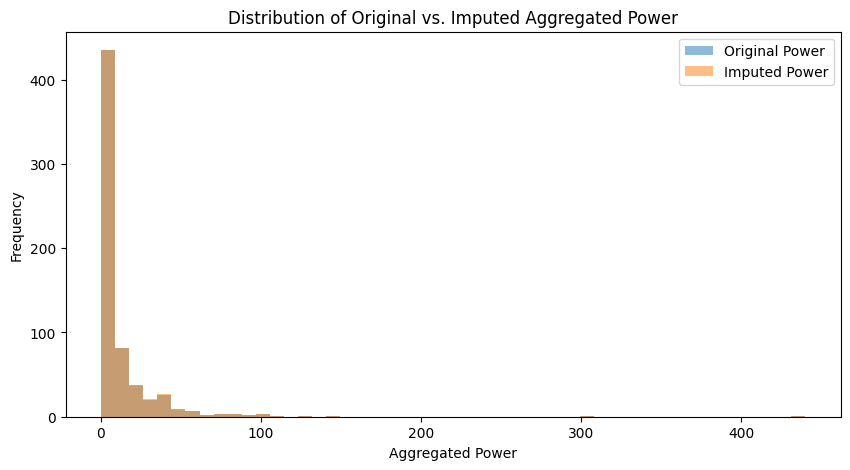

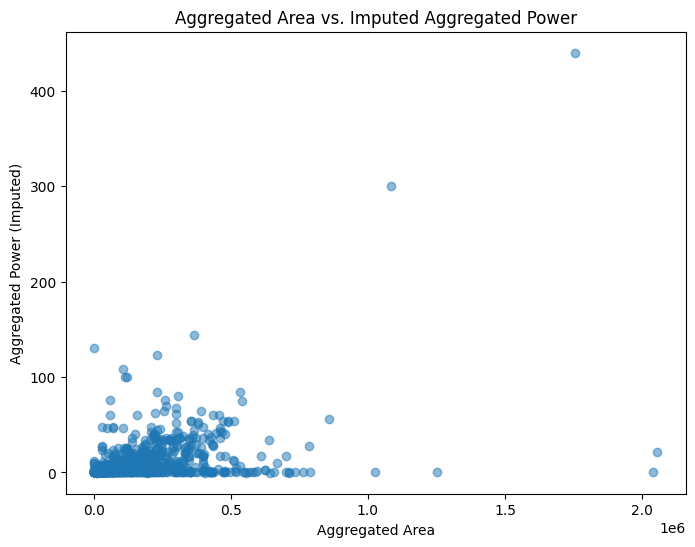

In [25]:
import matplotlib.pyplot as plt

# Compare distribution of original and imputed power (for rows where original is available)
df_non_missing = df[df['aggregated_power'].notna()]

plt.figure(figsize=(10, 5))
plt.hist(df_non_missing['aggregated_power'], bins=50, alpha=0.5, label='Original Power')
plt.hist(df_non_missing['aggregated_power_imputed'], bins=50, alpha=0.5, label='Imputed Power')
plt.xlabel("Aggregated Power")
plt.ylabel("Frequency")
plt.title("Distribution of Original vs. Imputed Aggregated Power")
plt.legend()
plt.show()

# (Optional) Scatter plot of aggregated_area vs. aggregated_power_imputed to see the relationship
plt.figure(figsize=(8, 6))
plt.scatter(df['aggregated_area'], df['aggregated_power_imputed'], alpha=0.5)
plt.xlabel("Aggregated Area")
plt.ylabel("Aggregated Power (Imputed)")
plt.title("Aggregated Area vs. Imputed Aggregated Power")
plt.show()

1. **Imputation and Remaining Missing Data**  
   -  used a robust/improved model (XGBoost or Random Forest with segmentation) to impute `aggregated_power` wherever we had enough predictor data (`aggregated_area`, `data_center_count`, `yearbuilt`, and facility_type).  
   - After this step, about **16%** of the rows still lacked the necessary predictors and thus remain without an imputed power value.

2. **Decision to Proceed**  
   - concluded that **84%** of the dataset now has an imputed (or original) `aggregated_power` value, which is sufficient for most downstream analyses.  
   - The remaining **16%** may be omitted from further analyses due to incomplete data.


# Concise Summary of Power Estimation Process

- **Data Preparation:**
  - Copied the original dataset (`facilities_with_yob`) and extracted state information from `full_address`.
  - Preserved the original facility type for later segmentation.

- **Feature Engineering:**
  - Applied log transformations to both `aggregated_power` and `aggregated_area` to mitigate skew.
  - Converted `facility_type` into dummy variables for use as predictors.

- **Model Training:**
  - **Facility-Specific Models:** Trained XGBoost regressors on log-transformed predictors (log_area, data_center_count, yearbuilt, and facility type dummies) for facility types with sufficient data (≥30 samples).
  - **Global Model:** Trained an XGBoost regressor on all complete cases as a fallback.

- **Imputation:**
  - For rows missing `aggregated_power` (i.e., `log_power`), used the facility-specific model if available; otherwise, applied the global model.
  - Converted the predicted log values back to the original scale to obtain `aggregated_power_imputed`.

- **Outcome:**
  - Approximately 84% of the dataset now has an imputed power value, while 16% remain missing due to insufficient predictor data.

In [33]:
df.to_csv("imputed_dataset.csv", index=False)